## Introduction
This dataset has various wafer resolution with class imbalanced. so we just consider specific subset wafer that has 26x26 resolution.<br> 
and solve imbalance problem using 2D convolutional autoencoder. then, classfy faulty case labels.

In [2]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


['LSWMD.pkl']


### Read data

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


* The dataset comprises **811,457 wafer maps**, along with additional information such as **wafer die size**, **lot name** and **wafer index**. 

* The training / test set were already split in this dataset, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

>Target distribution

In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


*  we do not need wafer index feature in our classification so we can just drop the variable. 

In [6]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.


In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
440873,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot26840,[],[],"(31, 31)"
407233,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6716.0,lot24341,[],[],"(95, 89)"
409767,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1970.0,lot24443,[],[],"(51, 50)"
45949,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",939.0,lot3927,[],[],"(39, 31)"
71970,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot5399,[],[],"(33, 33)"


In [8]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [9]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [10]:
tol_wafers = df.shape[0]
tol_wafers

811457

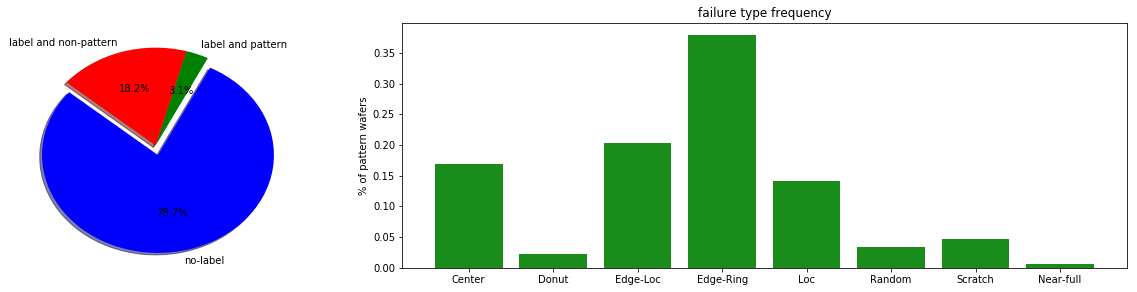

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

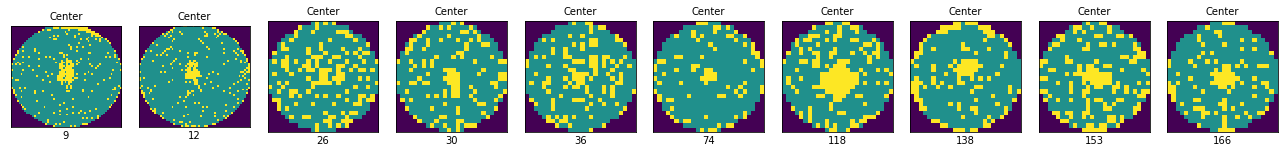

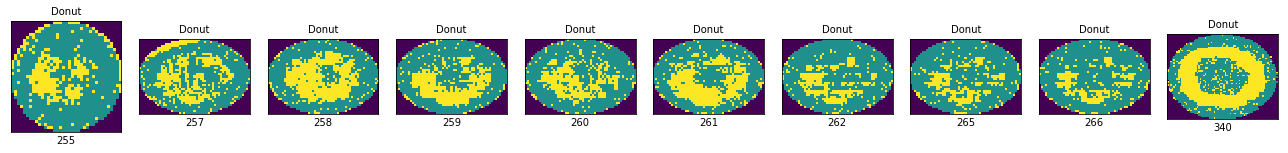

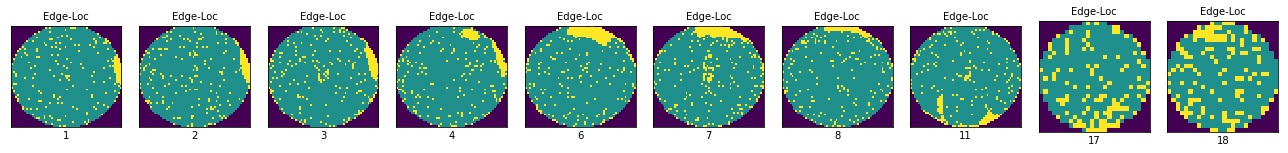

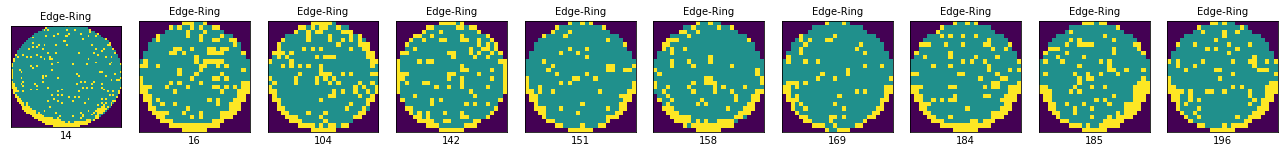

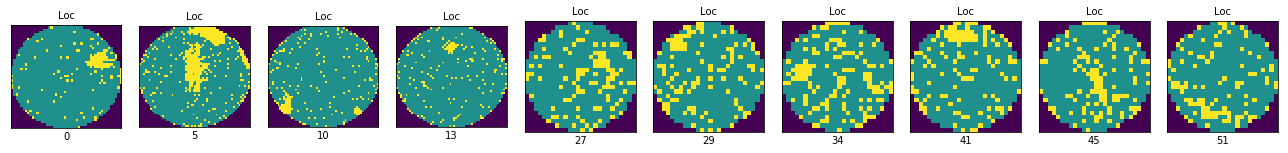

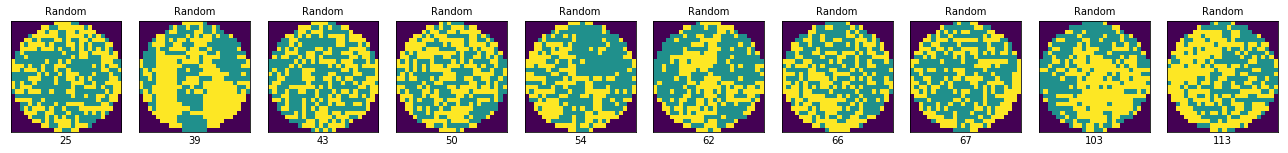

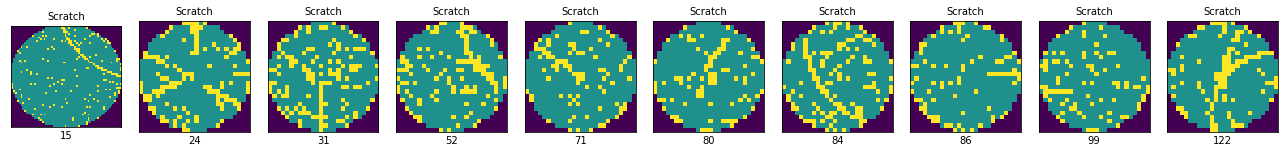

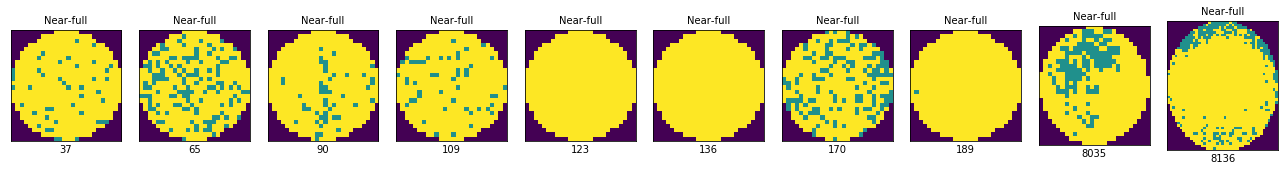

In [12]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

## Get sub wafer with specific resolution.
getting wafers having (26, 26) resolution. rarrange wafer nd-array with fautly case label.<br>
some wafer has null label, so we skip it.

In [13]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [14]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [15]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


plot 1st data for check.

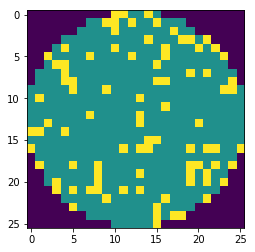

Faulty case : ['none'] 


In [16]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

We will use 2D Convolutional Autoencoder, extend dimension for channel.

In [17]:
#add channel
x = x.reshape((-1, 26, 26, 1))

Make faulty case list, and check how classes imbalanced.

In [18]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [19]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty. <br>
Extending extra dimension with one-hot-encoded categorical data as channel. <br>

In [20]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [21]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

## Convolutional Autoencoder for augmentation.
As solving class imbalanced problem, we need for data augmentation. <br>
The wafer data is image data. so we use convolutional autoencoder.

In [22]:
# parameter
epoch=15
batch_size=1024

In [23]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Check summary

In [24]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________


In [25]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
 - 30s - loss: 0.1497
Epoch 2/15
 - 29s - loss: 0.0950
Epoch 3/15
 - 29s - loss: 0.0839
Epoch 4/15
 - 29s - loss: 0.0733
Epoch 5/15
 - 29s - loss: 0.0647
Epoch 6/15
 - 29s - loss: 0.0581
Epoch 7/15
 - 29s - loss: 0.0525
Epoch 8/15
 - 29s - loss: 0.0475
Epoch 9/15
 - 29s - loss: 0.0425
Epoch 10/15
 - 28s - loss: 0.0375
Epoch 11/15
 - 29s - loss: 0.0331
Epoch 12/15
 - 29s - loss: 0.0294
Epoch 13/15
 - 29s - loss: 0.0264
Epoch 14/15
 - 29s - loss: 0.0239
Epoch 15/15
 - 29s - loss: 0.0219


In [26]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [27]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [28]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [29]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

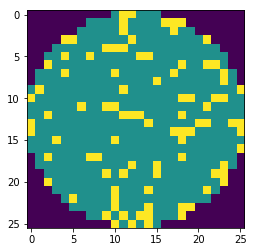

In [30]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

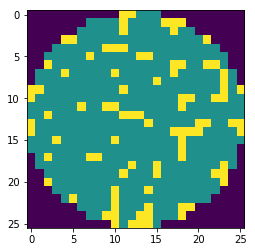

In [31]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

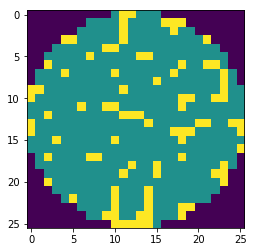

In [32]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

## Data augmentation
We made convolutional autoencoder model for data augmentation.<br>
We just want data has 2000 samples for each case. Let's augment data for all faulty case.

In [33]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [34]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [35]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [36]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [37]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [38]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [39]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [40]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [41]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [42]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [43]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


## Simple 2D CNN Model
The data is ready. As wafer data is image. simply use cnn for classification.<br>
### Make model
define create model function, because we will validate model with sklearn kfold cross validation.

In [44]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

### Cross validate model
Using sklearn KFold Cross validation, we validate our simple cnn.

In [45]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
 - 103s - loss: 2.8659 - acc: 0.2561
Epoch 2/10
 - 77s - loss: 1.2220 - acc: 0.5762
Epoch 3/10
 - 76s - loss: 0.6202 - acc: 0.7699
Epoch 4/10
 - 76s - loss: 0.3649 - acc: 0.8866
Epoch 5/10
 - 76s - loss: 0.3146 - acc: 0.9148
Epoch 6/10
 - 76s - loss: 0.4624 - acc: 0.8728
Epoch 7/10
 - 76s - loss: 0.2838 - acc: 0.9375
Epoch 8/10
 - 75s - loss: 0.1330 - acc: 0.9618
Epoch 9/10
 - 102s - loss: 0.0829 - acc: 0.9764
Epoch 10/10
 - 76s - loss: 0.0567 - acc: 0.9847
Epoch 1/10
 - 79s - loss: 1.9673 - acc: 0.3848
Epoch 2/10
 - 77s - loss: 1.0289 - acc: 0.6285
Epoch 3/10
 - 79s - loss: 0.6815 - acc: 0.7885
Epoch 4/10
 - 76s - loss: 0.3342 - acc: 0.8985
Epoch 5/10
 - 76s - loss: 0.1877 - acc: 0.9392
Epoch 6/10
 - 76s - loss: 0.1232 - acc: 0.9672
Epoch 7/10
 - 104s - loss: 0.0684 - acc: 0.9822
Epoch 8/10
 - 75s - loss: 0.0399 - acc: 0.9918
Epoch 9/10
 - 76s - loss: 0.0254 - acc: 0.9948
Epoch 10/10
 - 75s - loss: 0.0173 - acc: 0.9961
Epoch 1/10
 - 79s - loss: 1.7424 - acc: 0.4344
Epoch 2/

Our model seems quite a good model.

In [46]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         )

Train on 13203 samples, validate on 6504 samples
Epoch 1/15
 - 139s - loss: 2.0915 - acc: 0.3605 - val_loss: 0.9390 - val_acc: 0.6957
Epoch 2/15
 - 155s - loss: 1.0938 - acc: 0.6396 - val_loss: 0.9020 - val_acc: 0.6810
Epoch 3/15
 - 132s - loss: 0.6489 - acc: 0.7998 - val_loss: 0.4801 - val_acc: 0.8392
Epoch 4/15
 - 132s - loss: 0.3802 - acc: 0.8733 - val_loss: 0.2803 - val_acc: 0.9136
Epoch 5/15
 - 134s - loss: 0.1951 - acc: 0.9432 - val_loss: 0.1517 - val_acc: 0.9522
Epoch 6/15
 - 156s - loss: 0.1058 - acc: 0.9714 - val_loss: 0.0853 - val_acc: 0.9726
Epoch 7/15
 - 131s - loss: 0.0546 - acc: 0.9858 - val_loss: 0.0516 - val_acc: 0.9879
Epoch 8/15
 - 131s - loss: 0.0346 - acc: 0.9923 - val_loss: 0.0432 - val_acc: 0.9883
Epoch 9/15
 - 131s - loss: 0.0227 - acc: 0.9948 - val_loss: 0.0341 - val_acc: 0.9892
Epoch 10/15
 - 135s - loss: 0.0192 - acc: 0.9951 - val_loss: 0.0354 - val_acc: 0.9892
Epoch 11/15
 - 157s - loss: 0.0123 - acc: 0.9977 - val_loss: 0.0360 - val_acc: 0.9871
Epoch 12/15
 -

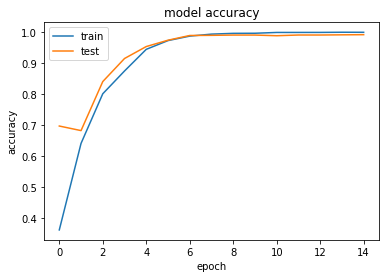

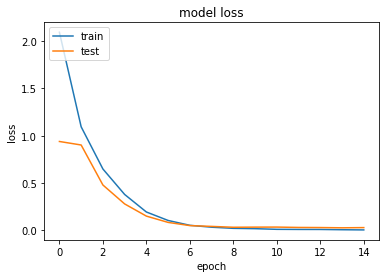

In [47]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
prediction = model.predict(x_test)
print(prediction)
print(y_test)

[8 5 1 ... 7 1 2]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [57]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))